# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='notebook_ims/style_tx_cat.png' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

In [0]:
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms,models
import matplotlib.pyplot as plt
%matplotlib inline

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [0]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load in content and style image

In [0]:
def load_image(image_path,max_Size=400,shape=None):
    image = Image.open(image_path).convert('RGB')
    if max(image.size)>max_Size:
        size = max_Size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))
            ])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [0]:
content = load_image('cat.png').to(device)
style = load_image('hokusai.jpg',shape=content.shape[-2:]).to(device)

### function for getting normal image

In [0]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

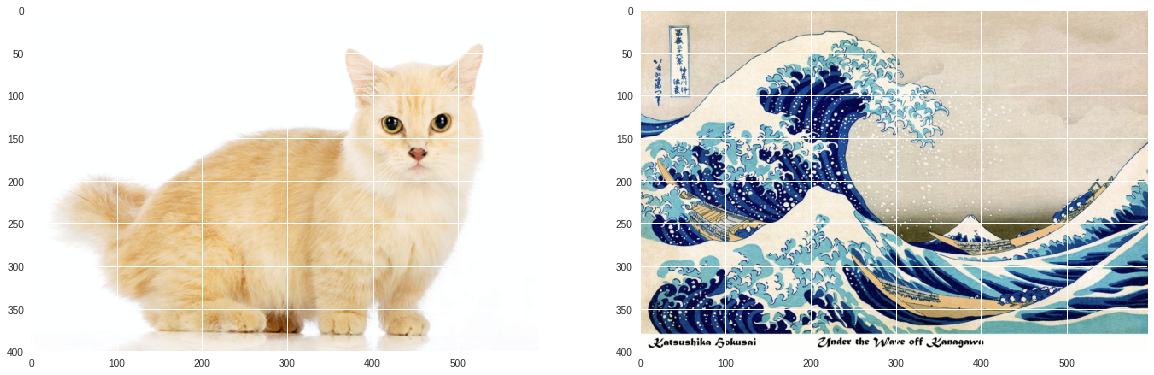

In [8]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

### Function for getting features through VGG net

In [0]:
def get_features(image,model,layers=None):
    if layers is None:
        layers = {
                '0': 'conv1_1',
                '5': 'conv2_1',
                '10': 'conv3_1',
                '19': 'conv4_1',
                '21': 'conv4_2',   # content representation
                '28': 'conv5_1'
        }
    features = {}
    x = image
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features
        

### Function for computing Gram Matrix

In [0]:
def gram_matrix(tensor):
    
    _,d,h,w = tensor.size()
    tensor = tensor.view( d, h*w )
    gram  = torch.mm(tensor,tensor.t())
    
    return gram

In [0]:
content_features = get_features(content,vgg)
style_features = get_features(style,vgg)

In [0]:
style_grams = {layer: gram_matrix(style_features[layer])  for layer in style_features }

In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {
                'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2
}
content_weight = 1
style_weight = 1e6

### Training code

steps is :  200
Total loss:  233864336.0


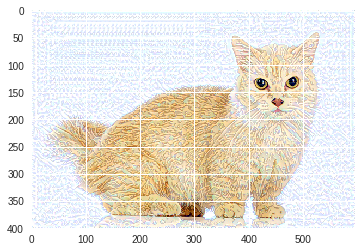

steps is :  400
Total loss:  138593328.0


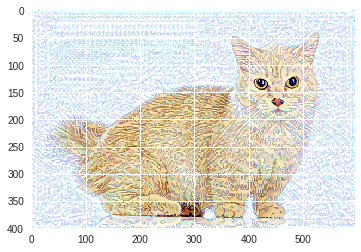

steps is :  600
Total loss:  95019384.0


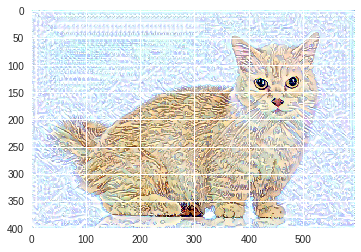

steps is :  800
Total loss:  67191544.0


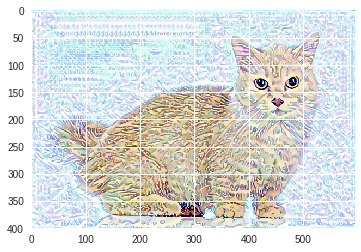

steps is :  1000
Total loss:  47693980.0


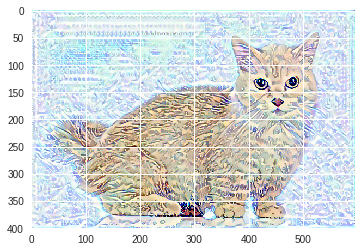

steps is :  1200
Total loss:  33678480.0


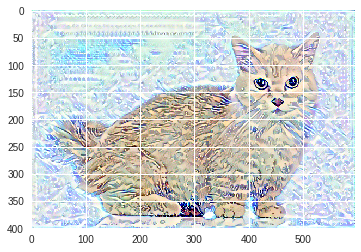

steps is :  1400
Total loss:  23581876.0


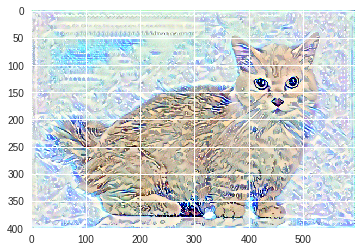

steps is :  1600
Total loss:  16452271.0


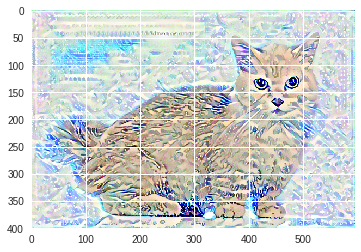

steps is :  1800
Total loss:  11688544.0


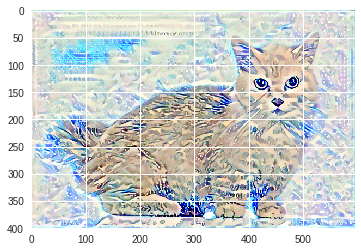

steps is :  2000
Total loss:  8610228.0


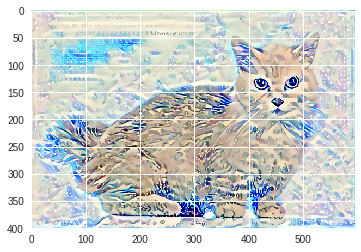

steps is :  2200
Total loss:  6593993.0


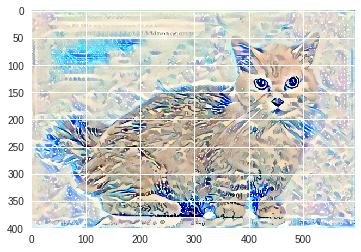

steps is :  2400
Total loss:  5228493.0


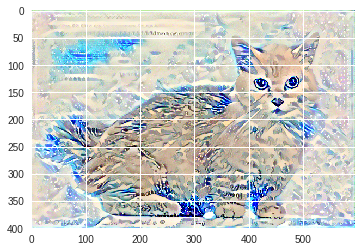

steps is :  2600
Total loss:  4269799.0


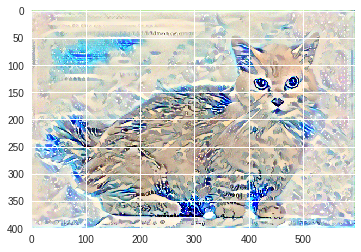

steps is :  2800
Total loss:  3568800.0


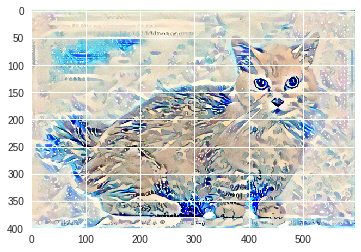

steps is :  3000
Total loss:  3033472.0


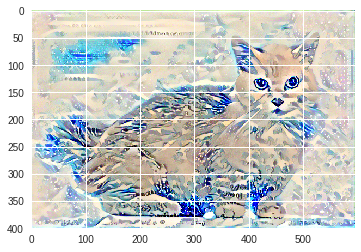

In [17]:
# for displaying the target image, intermittently
show_every = 200

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 3000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    if ii % show_every==0:
      print('steps is : ',ii)
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

### Final stylised image of cat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':


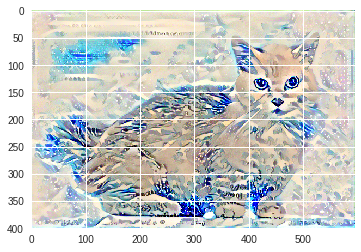

In [21]:
image = im_convert(target)

plt.imshow(image)
